In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [98]:
df = yf.download('GOOG', start='2015-01-01', end='2019-12-31', adjusted=True, progress=False)
goog = df.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [99]:
goog_diff = goog.diff().dropna()

In [100]:
goog_diff

Date
2015-01-11   -28.561615
2015-01-18    11.877380
2015-01-25    31.782745
2015-02-01    -5.415100
2015-02-08    -3.510376
                ...    
2019-12-08    35.660034
2019-12-15     7.209961
2019-12-22     1.760010
2019-12-29     2.300049
2020-01-05   -15.750000
Freq: W-SUN, Name: adj_close, Length: 261, dtype: float64

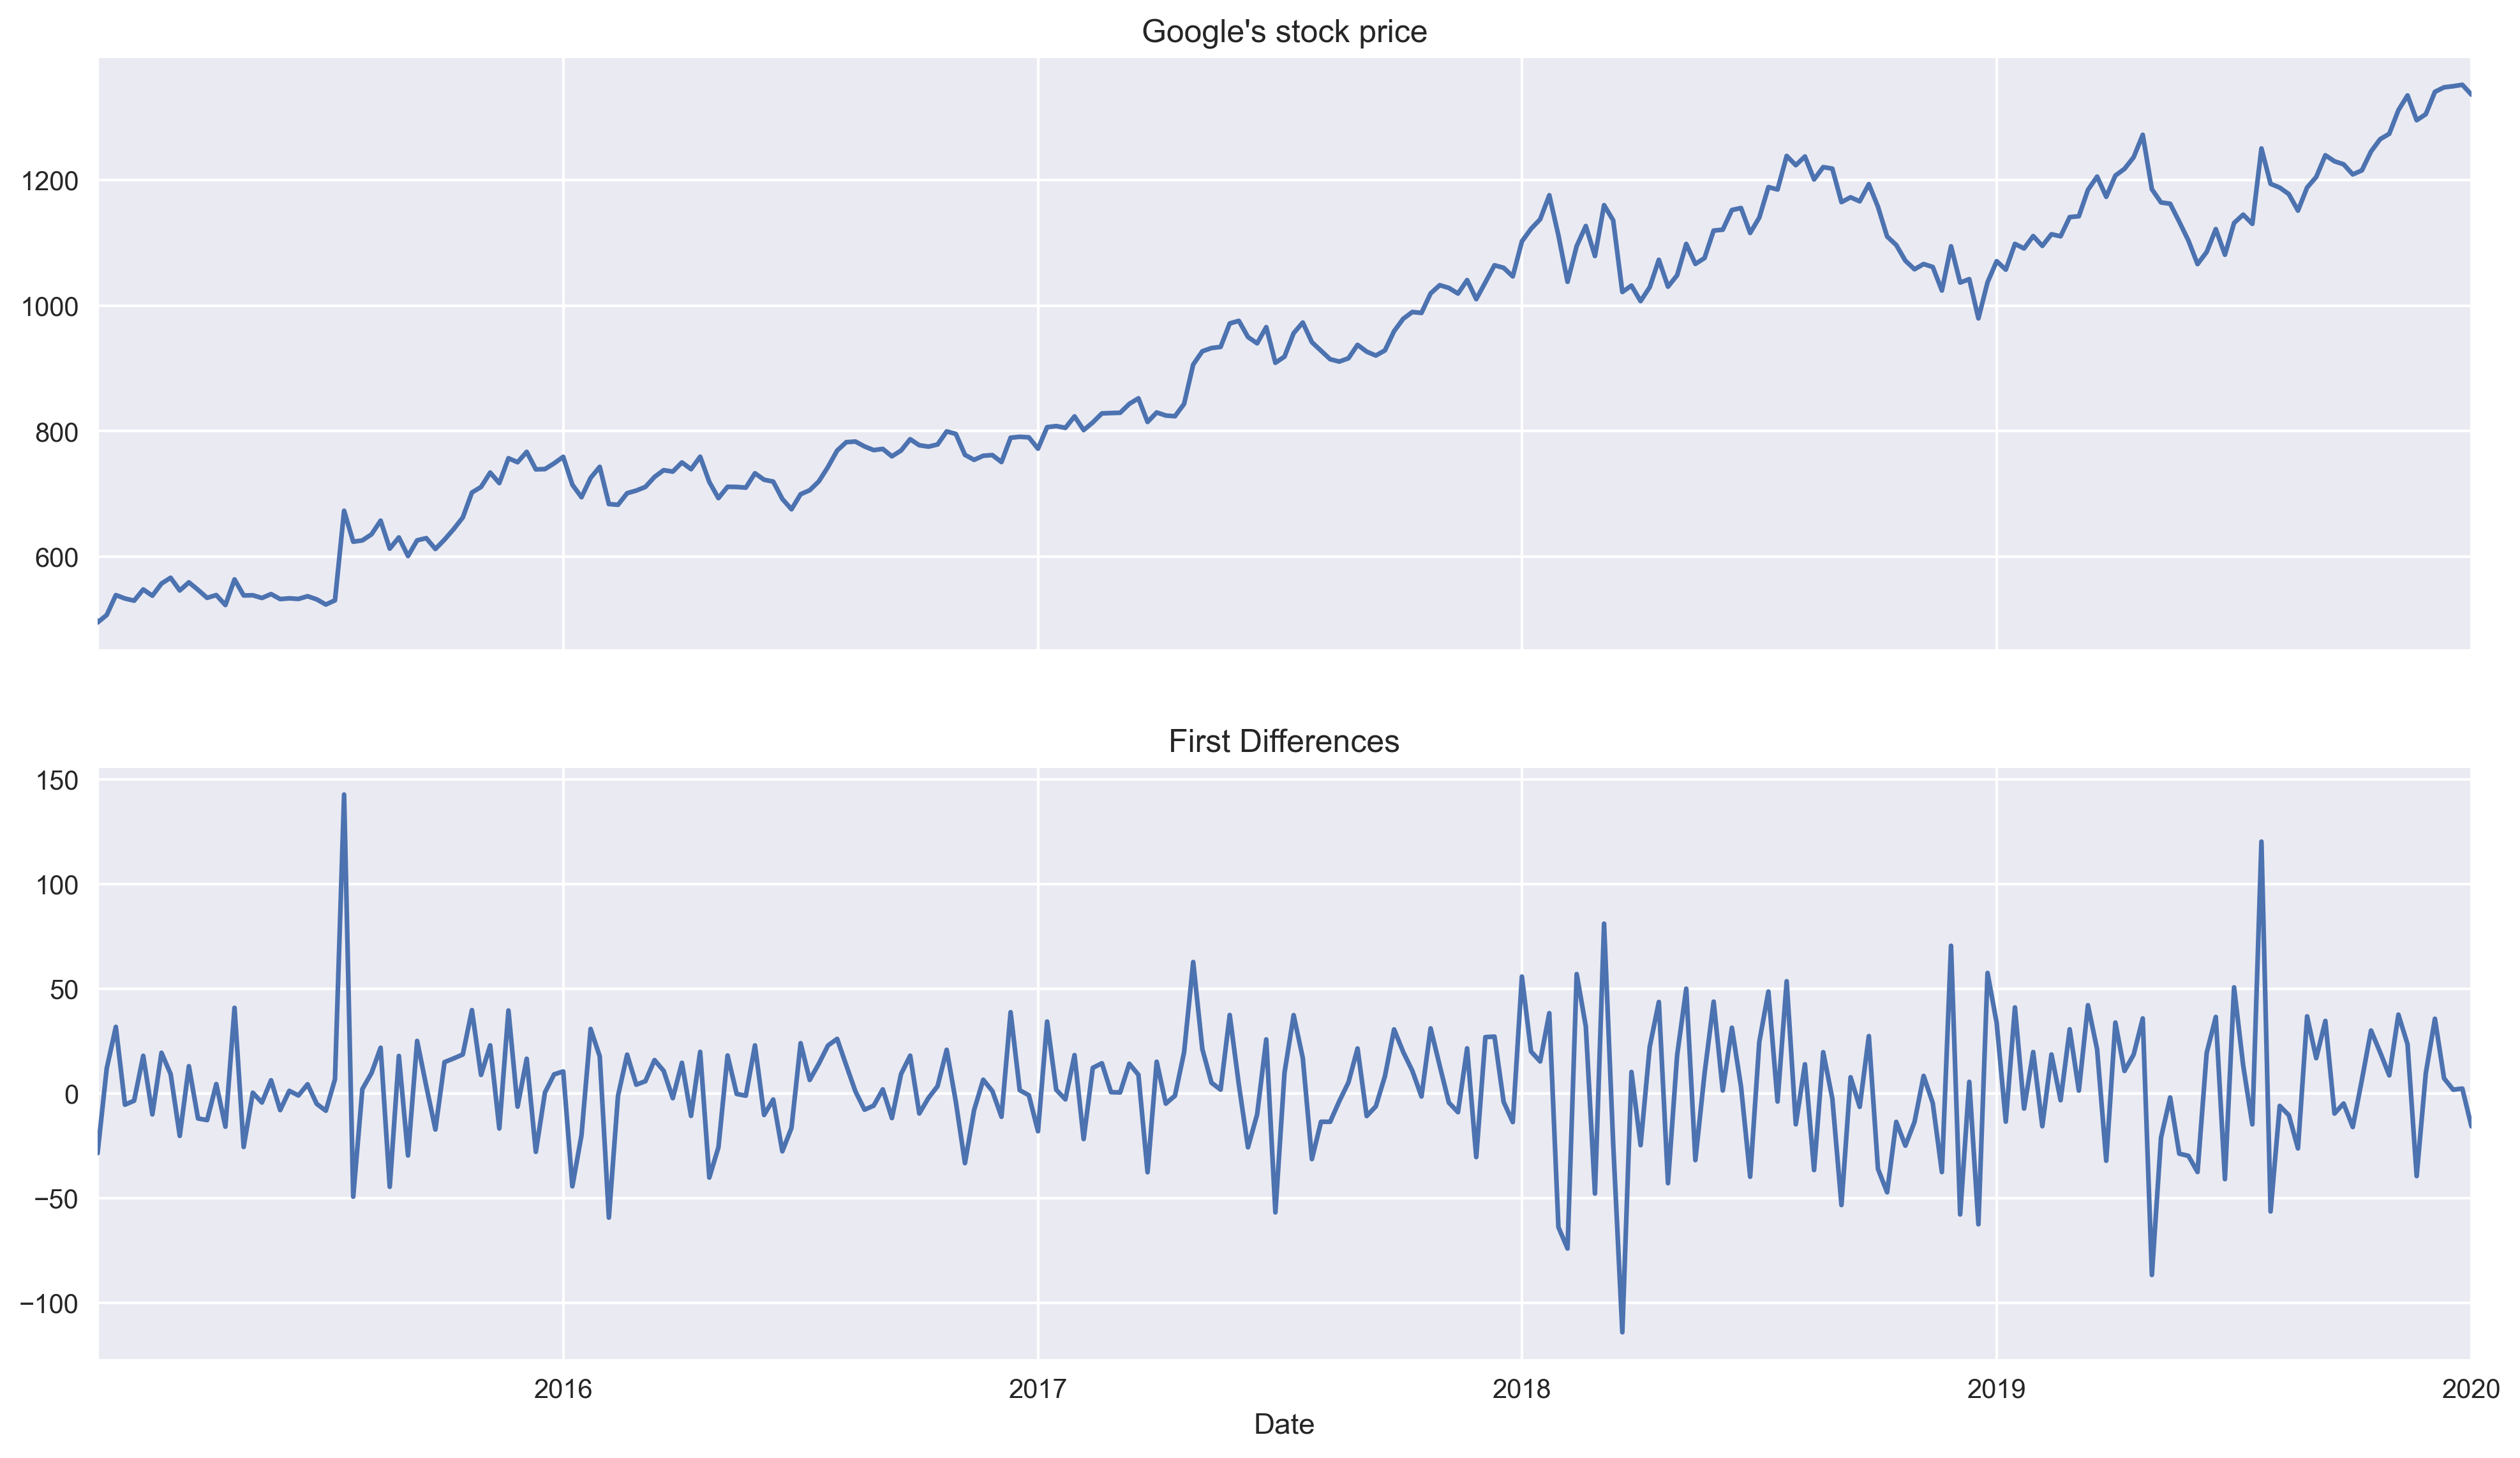

In [101]:
fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

In [102]:
result = adfuller(goog_diff)
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.038741914002012
p-value : 3.332823636587121e-26
#Lags Used : 1
Number of Observations Used : 259
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


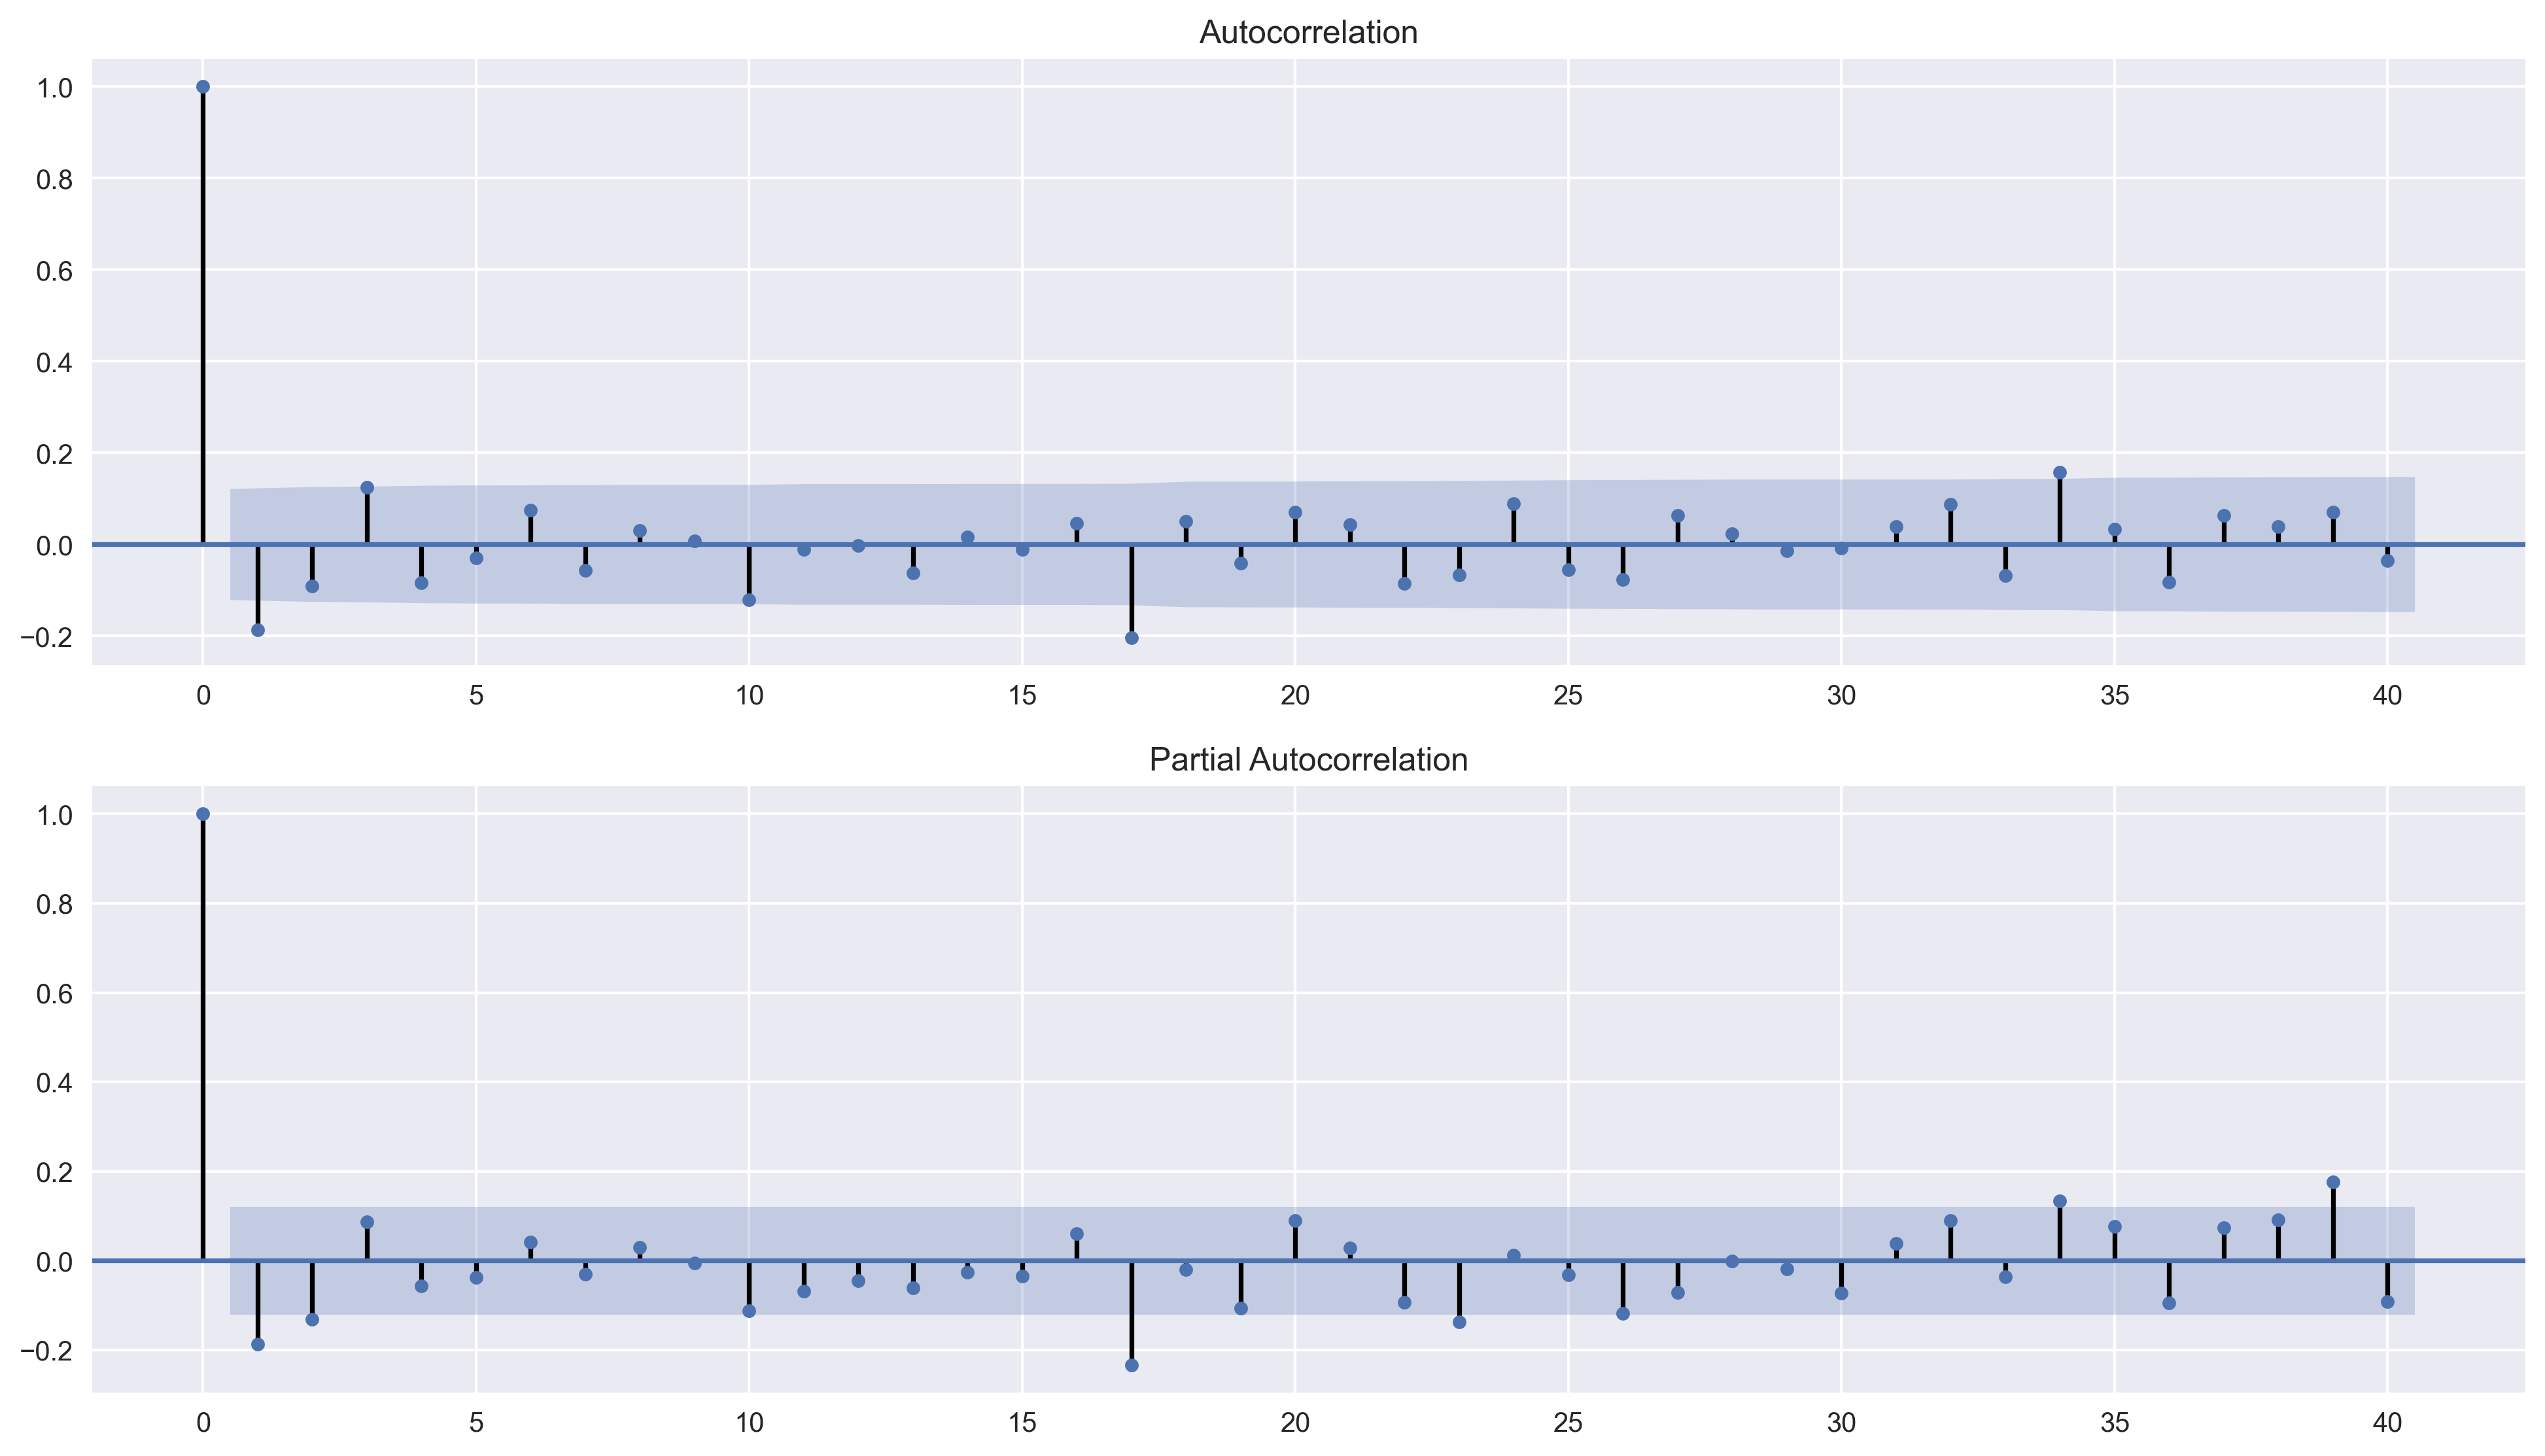

In [103]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2,1)
plot_acf(goog_diff, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(goog_diff, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL);

In [148]:
arima = ARIMA(goog, order=(3,1,3)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  261
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1240.916
Method:                       css-mle   S.D. of innovations             27.948
Date:                Sun, 12 Apr 2020   AIC                           2497.832
Time:                        01:26:33   BIC                           2526.349
Sample:                    01-11-2015   HQIC                          2509.295
                         - 01-05-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.0082      0.202     14.881      0.000       2.612       3.404
ar.L1.D.adj_close     0.0222      0.209      0.106      0.916      -0.388       0.433
ar.L2.D.adj_close     0.1567      0.194      0.809      0.419      -0.223       0.536
ar.L3.D.adj_close     0.5940      0.199      2.989      0.003       0.205       0.984
ma.L1.D.adj_close    -0.2479      0.238     -1.044      0.298      -0.713       0.218
ma.L2.D.adj_close    -0.2609      0.228     -1.145      0.253      -0.707       0.186
ma.L3.D.adj_close    -0.4912      0.263     -1.871      0.062      -1.006       0.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0981           -0.0000j            1.0981           -0.0000
AR.2           -0.6810           -1.0341j            1.2381           -0.3427
AR.3           -0.6810           +1.0341j            1.2381            0.3427
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.7656           -1.2041j            1.4268           -0.3401
MA.3           -0.7656           +1.2041j            1.4268            0.3401
-----------------------------------------------------------------------------
"""

In [149]:
import seaborn as sns

def arima_diagnostics(resids, n_lags=40):
    #create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    
    r = resids
    resids= (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    #residuals over time
    sns.lineplot(x = np.arange(len(resids)), y = resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    #distribution of residuals
    x_lim = (-1.96*2, 1.96*2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist=True, kde=True, norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('distribution of standardized residuals')
    ax2.legend()
    
    #Q-Q plot
    qq=sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')
    
    #ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.5)
    ax4.set_title('ACF plot')
    
    return fig

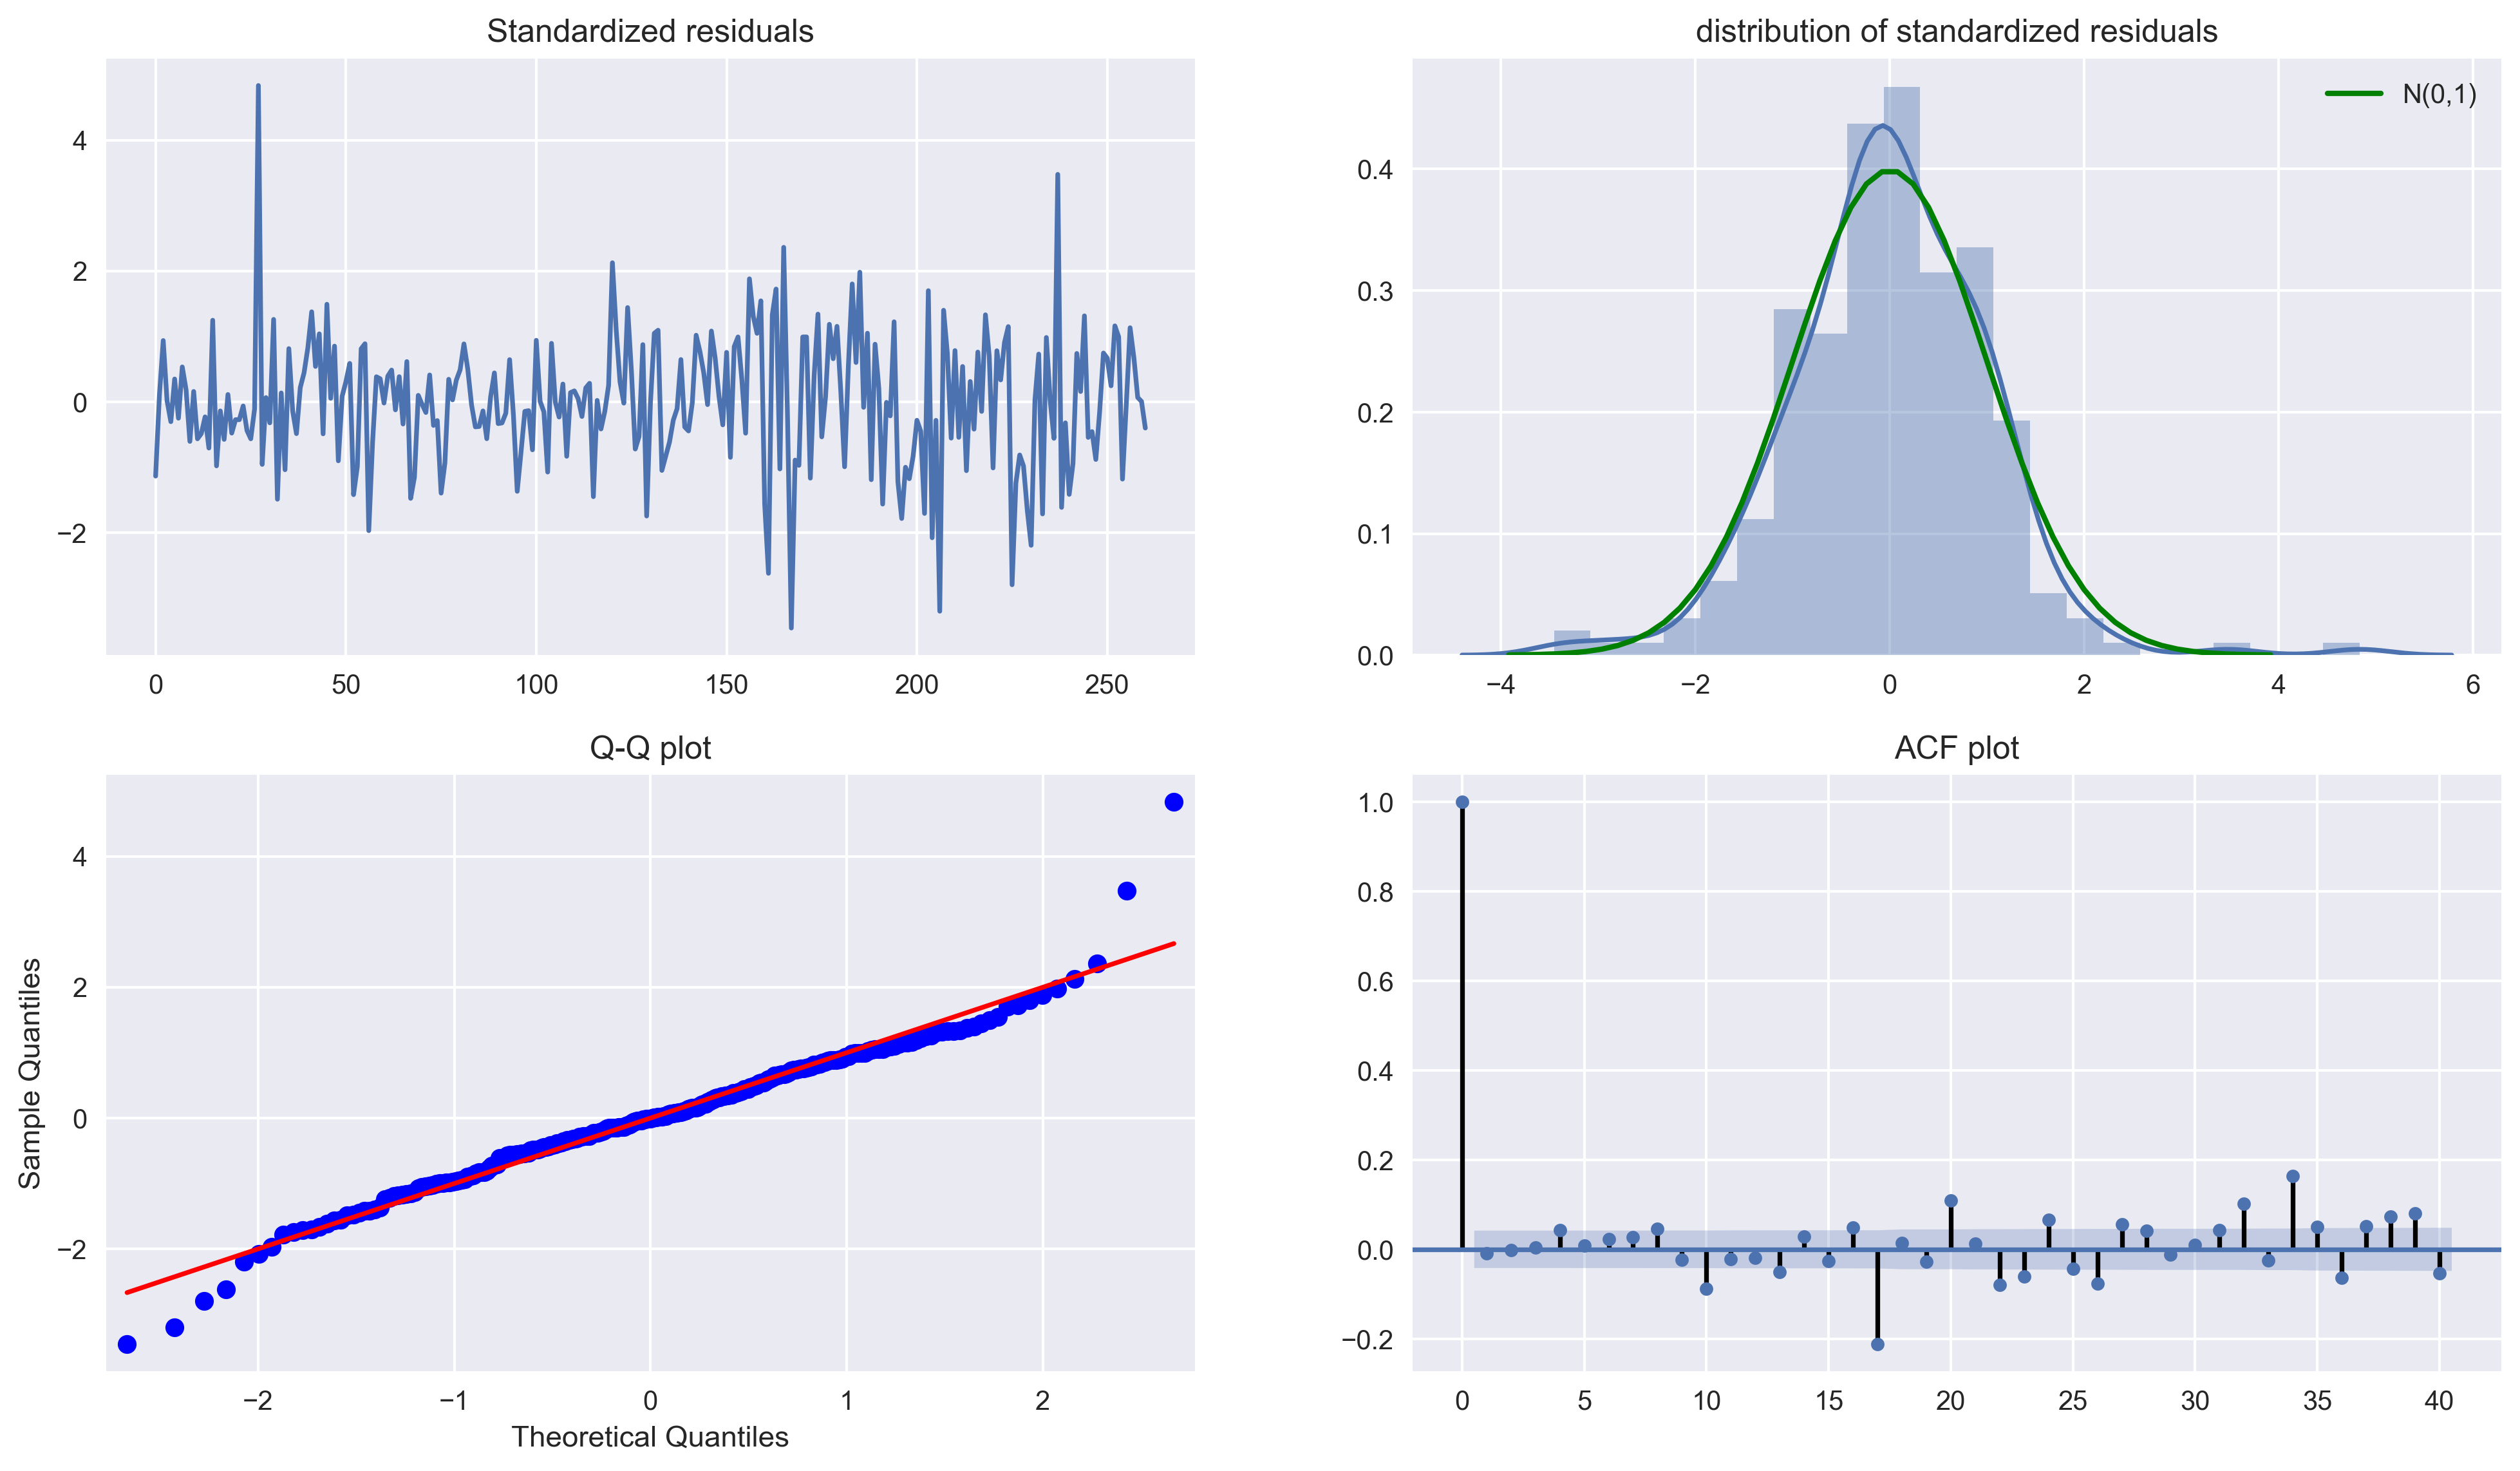

In [150]:
arima_diagnostics(arima.resid, 40);

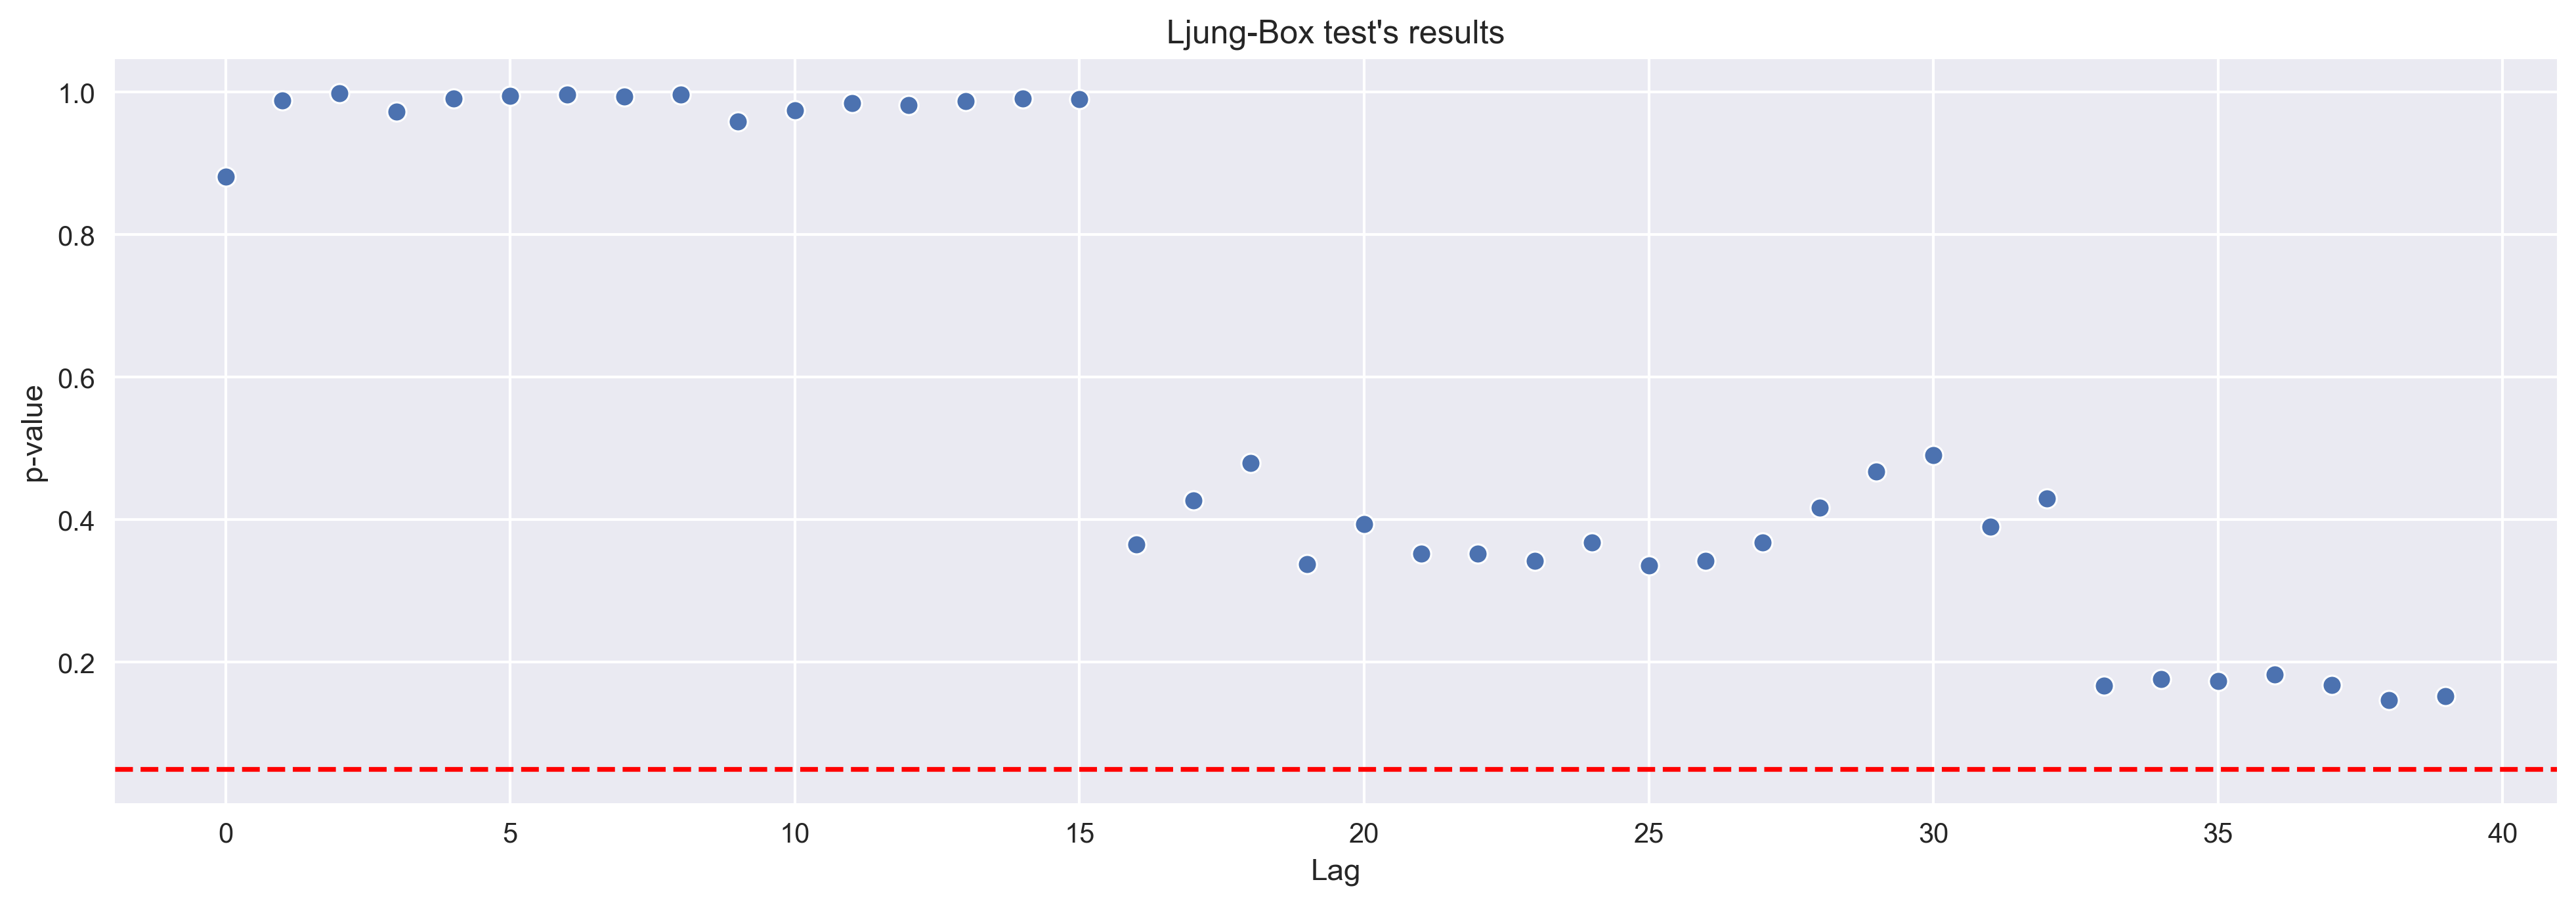

In [151]:
ljung_box_results = acorr_ljungbox(arima.resid)
fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results", xlabel='Lag', ylabel='p-value');

In [152]:
# use auto_arima for lowest AIC, so we could have a better model
import pmdarima as pm
model = pm.auto_arima(goog, error_action ='ignore', suppress_warnings=True, seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1248.207
Date:                Sun, 12 Apr 2020   AIC                           2502.414
Time:                        01:26:49   BIC                           2513.107
Sample:                             0   HQIC                          2506.712
                                - 262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1580      1.397      2.260      0.024       0.420       5.897
ma.L1         -0.2209      0.060     -3.688      0.000      -0.338      -0.104
sigma2       833.7188     44.946     18.549      0.000     745.627     921.811
===================================================================================
Ljung-Box (Q):                       55.60   Jarque-Bera (JB):               119.11
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
# let's search for better results
model = pm.auto_arima(goog, error_action='ignore', suppress_warnings=True, seasonal=False, stepwise=False, approximation=False, n_jobs=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1243.501
Date:                Sun, 12 Apr 2020   AIC                           2501.002
Time:                        01:26:59   BIC                           2525.953
Sample:                             0   HQIC                          2511.031
                                - 262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3248      4.930      1.891      0.059      -0.338      18.988
ar.L1         -1.4711      0.025    -58.376      0.000      -1.520      -1.422
ar.L2         -0.9678      0.026    -36.733      0.000      -1.019      -0.916
ma.L1          1.2942      0.065     19.819      0.000       1.166       1.422
ma.L2          0.6413      0.100      6.422      0.000       0.446       0.837
ma.L3         -0.2225      0.063     -3.505      0.000      -0.347      -0.098
sigma2       806.0982     44.429     18.144      0.000     719.019     893.177
===================================================================================
Ljung-Box (Q):                       48.00   Jarque-Bera (JB):               125.49
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
# let's further dig into details
df = yf.download('GOOG', start='2020-01-01', end='2020-04-12', adjusted=True, progress=False)
test = df.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [141]:
#obtain the forecast from second model and store it in a DataFrame
#the syntax are different than the next .predict method

n_forecasts = len(test)
arima_pred = arima.forecast(n_forecasts)
arima_pred = [pd.DataFrame(arima_pred[0], columns = ['prediction']),
                          pd.DataFrame(arima_pred[2], columns=['ci_lower', 'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

In [142]:
#obtain the forecast from second model and store it in a DataFrame
#the syntax are different than the previous .forecast method

auto_arima_pred = model.predict(n_periods=n_forecasts, return_conf_int=True, alpha=0.5)
auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']), 
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, axis=1).set_index(test.index)
auto_arima_pred

,prediction,ci_lower,ci_upper
Date,,,
2020-01-05,1349.672586,1330.519131,1368.826041
2020-01-12,1339.732864,1314.929147,1364.536582
2020-01-19,1354.930394,1326.202683,1383.658106
2020-01-26,1351.518305,1318.932710,1384.103900
2020-02-02,1351.154043,1315.154681,1387.153406
2020-02-09,1364.316978,1325.485099,1403.148857
2020-02-16,1354.630601,1312.734818,1396.526385
2020-02-23,1365.465430,1321.056587,1409.874273
2020-03-01,1368.226021,1321.330653,1415.121390


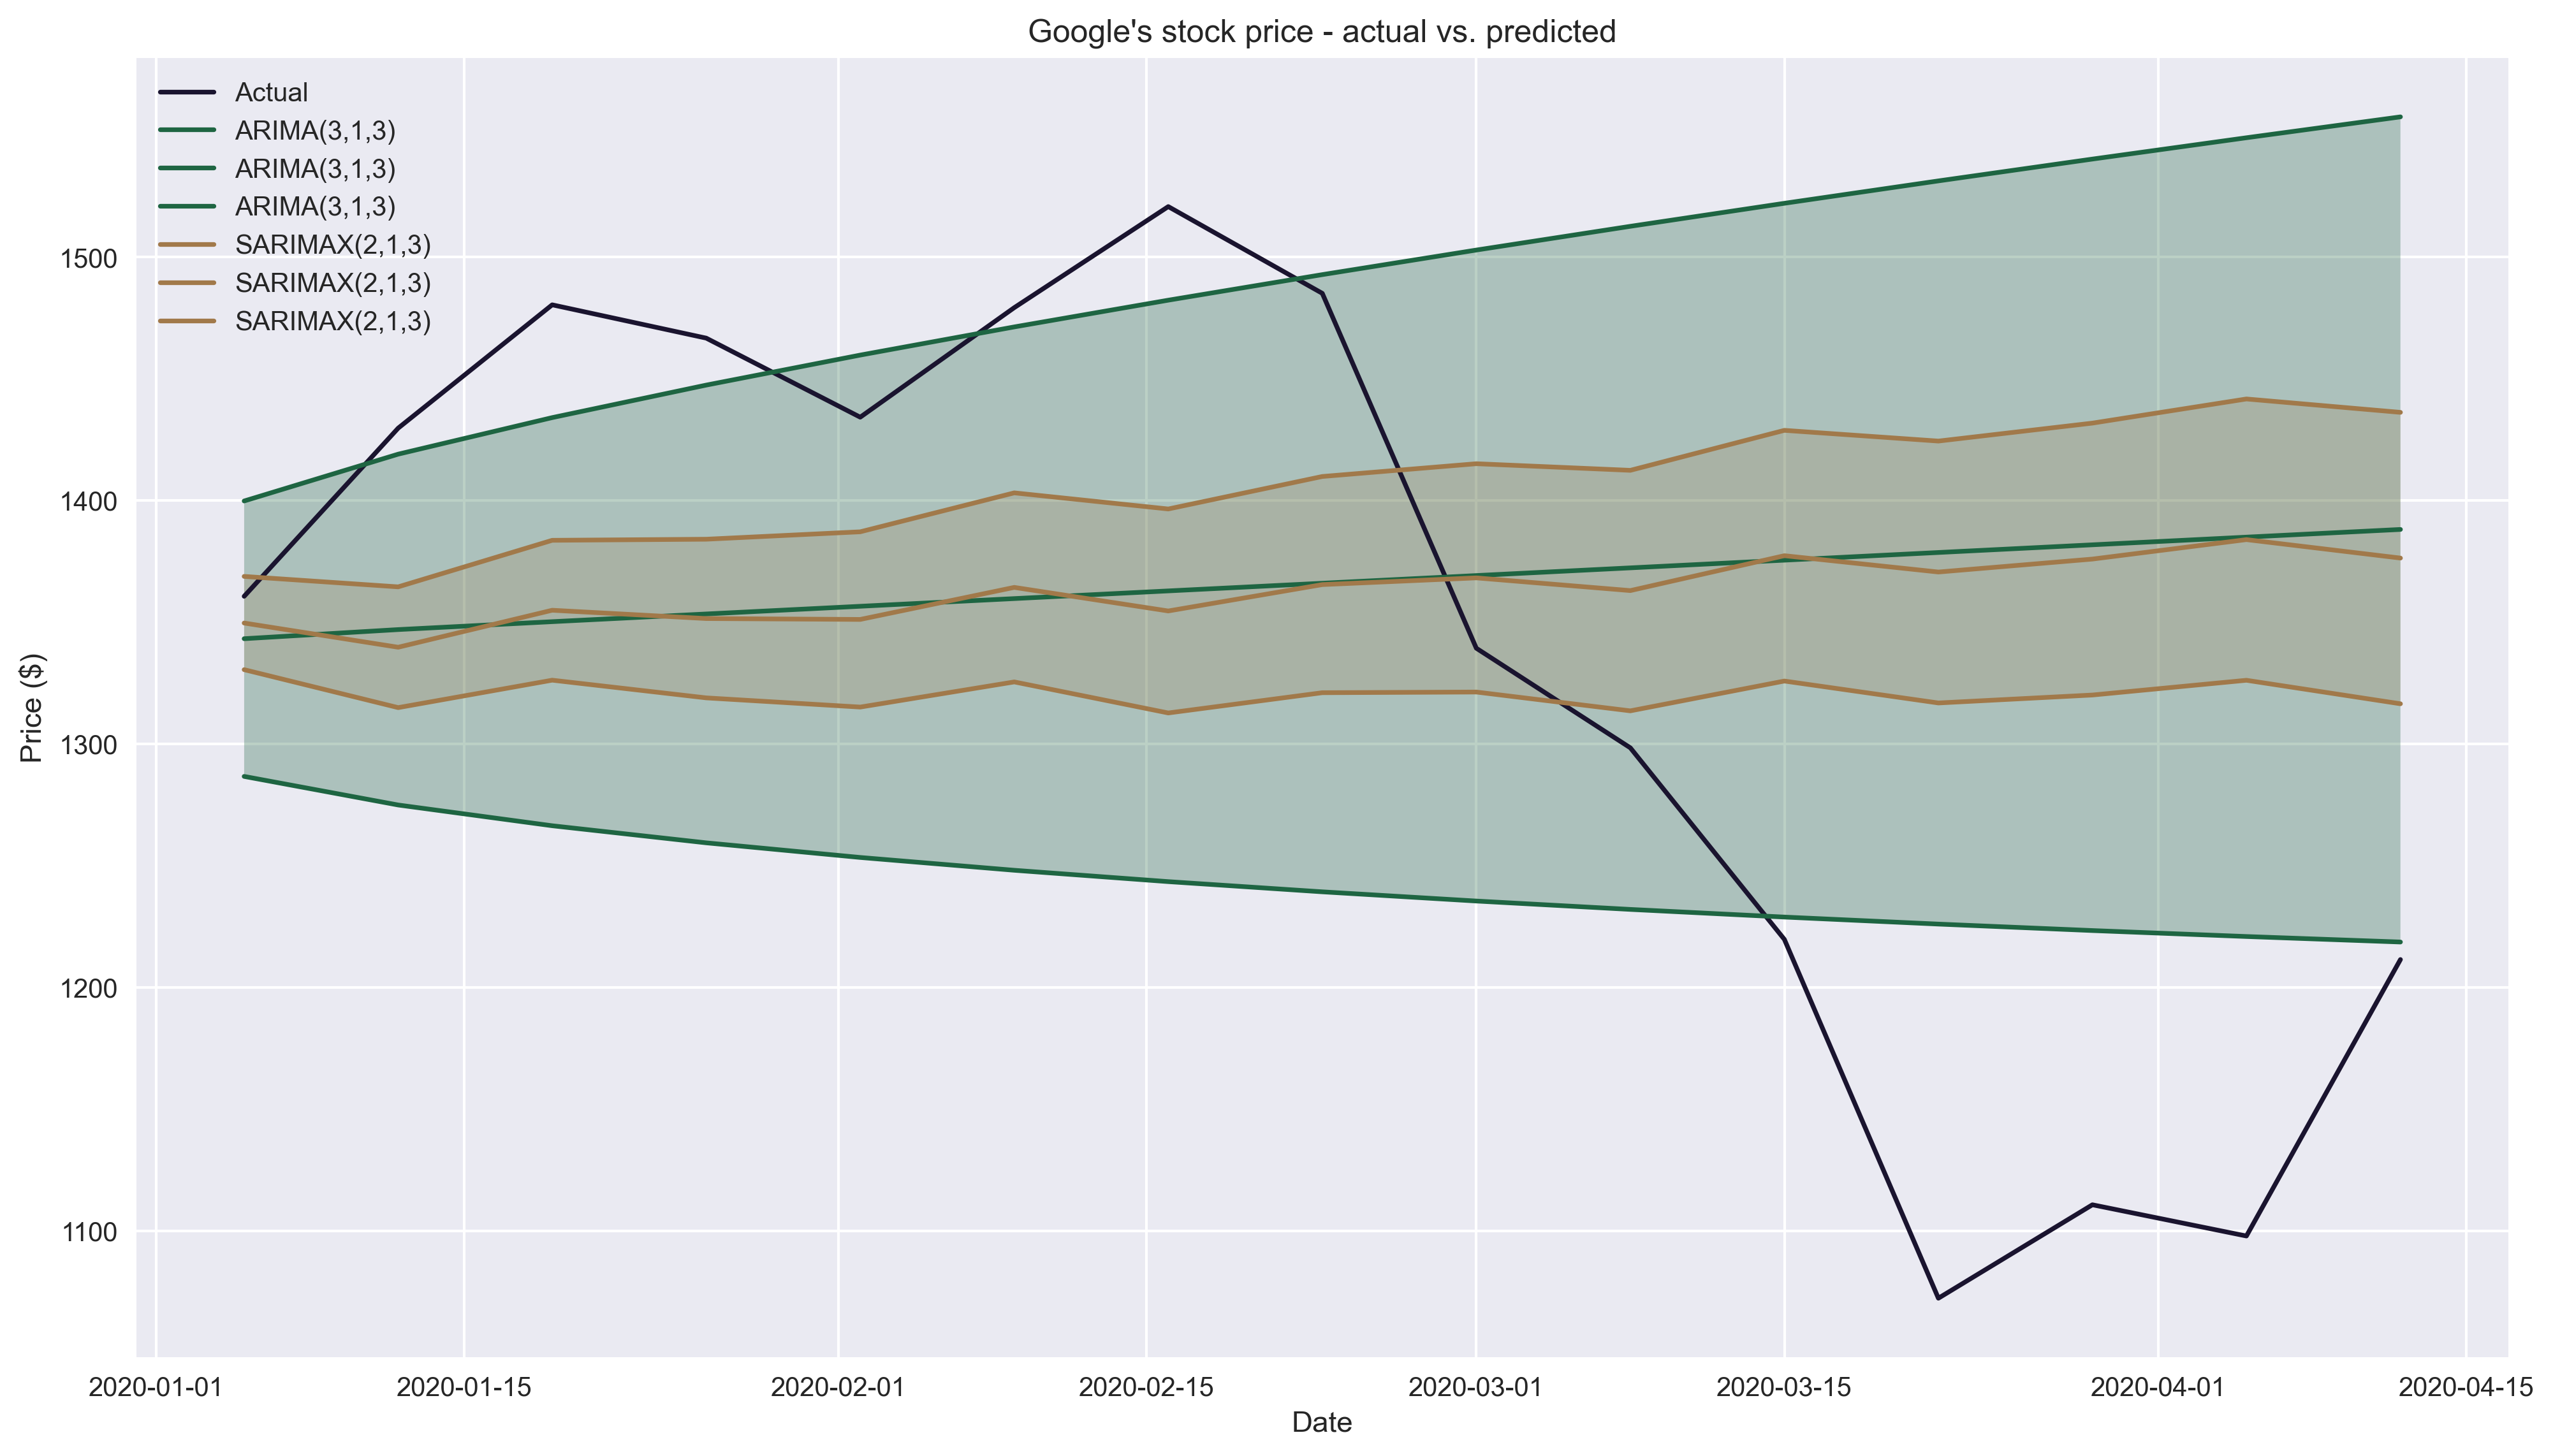

In [156]:
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

fig, ax = plt.subplots(1)
ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')
ax.plot(arima_pred, c=COLORS[1], label='ARIMA(3,1,3)')
ax.fill_between(arima_pred.index, arima_pred.ci_lower, 
                arima_pred.ci_upper, alpha=0.3, facecolor=COLORS[1])
ax.plot(auto_arima_pred, c=COLORS[2], label='SARIMAX(2,1,3)')
ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower,
                auto_arima_pred.ci_upper, alpha=0.2, facecolor=COLORS[2])
ax.set(title="Google's stock price - actual vs. predicted", xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left');